In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import librosa
import numpy as np

In [14]:
fs = 16000

# x_content, _ = librosa.load('eminem.mp3')
# x_style, _ = librosa.load('gettysburg.mp3')

# mel_content = librosa.feature.melspectrogram(y=x_content, sr=fs, n_mels=512, fmax=8000)
# mel_style = librosa.feature.melspectrogram(y=x_style, sr=fs, n_mels=512, fmax=8000)
N_FFT=2048

def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x,n_fft= N_FFT)
    p = np.angle(S)

    S = np.log1p(np.abs(S[:,:430]))
    return S, fs

a_content, fs = read_audio_spectum('content.mp3')
a_style, fs = read_audio_spectum('style.mp3')
# print(np.shape(mel_content))
# print(np.shape(mel_style))

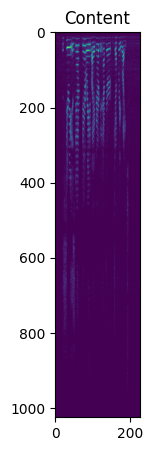

In [15]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,2, figsize=(10,4))
# S_1 = librosa.power_to_db(mel_content, ref=np.max)
# S_2 = librosa.power_to_db(mel_style, ref=np.max)
# img = librosa.display.specshow(S_1, x_axis='time',
#                          y_axis='mel', sr=fs,
#                          fmax=8000, ax=ax[0])
# img2 = librosa.display.specshow(S_2, x_axis='time',
#                          y_axis='mel', sr=fs,
#                          fmax=8000, ax=ax[1])
# ax[0].set(title='Mel content')
# ax[1].set(title='Mel style')


plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.title('Content')
plt.imshow(a_content)

In [16]:
N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, a_style.shape[1]-N_SAMPLES:]
N_FILTERS = 2048

In [17]:
a_content = torch.tensor(a_content)
a_content = torch.reshape(a_content, (1, N_CHANNELS, 1, N_SAMPLES))
a_style = torch.tensor(a_style)
a_style = torch.reshape(a_style, (1, N_CHANNELS, 1, N_SAMPLES))

In [31]:
#Can use nn.Sequential instead
class Shallow_net(nn.Sequential):
  def __init__(self, in_channel, out_channel):
    super(Shallow_net, self).__init__(nn.Conv2d(in_channel, out_channel, (1, 11)), nn.ReLU())

  # def forward(self, x):
  #   out = self.conv(x)
  #   out = self.relu(out)
  #   return out

def init_weights(m):
  if isinstance(m, nn.Conv2d):
    std = np.sqrt(2) * np.sqrt(2.0 / ((m.weight.shape[0]+m.weight.shape[1]) * 11))
    m.weight.data.normal_(std = std)

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

def gram_matrix(input, n_samples):
    a, b, c, d = input.size()
    features = input.reshape(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(n_samples)

class StyleLoss(nn.Module):
    def __init__(self, target_feature, n_samples):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature, n_samples).detach()
        self.n_samples = n_samples
    def forward(self, input):
        G = gram_matrix(input, self.n_samples)
        self.loss = F.mse_loss(G, self.target)
        return input

#Adjust layers
def adjust_net(net, nb_filters):
  index = 2
  net.add_module('conv_{}'.format(index), nn.Conv2d(N_FILTERS, nb_filters[0], (1,11)))
  net.add_module('relu_{}'.format(torch.index_add), nn.ReLU())
  for i in range(len(nb_filters)-1):
    net.add_module('conv_{}'.format(index), nn.Conv2d(nb_filters[i+1], nb_filters[i+1], (1,11)))
    net.add_module('relu_{}'.format(index), nn.ReLU())
    index += 1
  return net

In [36]:
net = Shallow_net(1025, N_FILTERS)
nb_filters = [2048]
net = adjust_net(net, nb_filters)
net.apply(init_weights)

a_input = a_content.clone().contiguous()

content_layer = ['relu_1']
style_layer = ['relu_1', 'relu_2']
style_losses = []
content_losses = []
i = 0

transfer_net = nn.Sequential()

for layer in net.children():
  if isinstance(layer, nn.Conv2d):
    i += 1
    name = "conv_{}".format(i)
  elif isinstance(layer, nn.ReLU):
    name = 'relu_{}'.format(i)

  transfer_net.add_module(name, layer)

  if name in content_layer:
    target_content = transfer_net(a_content).detach()
    content_loss = ContentLoss(target_content)
    transfer_net.add_module("Content_loss_conv_{}".format(i), content_loss)
    content_losses.append(content_loss)
  if name in style_layer:
    target_style = transfer_net(a_style).detach()
    style_loss = StyleLoss(target_style, N_SAMPLES)
    transfer_net.add_module("Style_loss_conv_{}".format(i), style_loss)
    style_losses.append(style_loss)

transfer_net.eval()
transfer_net.requires_grad_(False)

Sequential(
  (conv_1): Conv2d(1025, 2048, kernel_size=(1, 11), stride=(1, 1))
  (relu_1): ReLU()
  (Content_loss_conv_1): ContentLoss()
  (Style_loss_conv_1): StyleLoss()
  (conv_2): Conv2d(2048, 2048, kernel_size=(1, 11), stride=(1, 1))
  (relu_2): ReLU()
  (Style_loss_conv_2): StyleLoss()
)

In [38]:
def get_input_optimizer(input_audio):
    optimizer = optim.LBFGS([input_audio])
    return optimizer

In [39]:
#Initialization
num_iter = 100
style_weight = 100000
content_weight = 1

a_input.requires_grad_(True)

optimizer = get_input_optimizer(a_input)

print('Optimizing...')

run = [0]
while run[0] <= num_iter:

  def closure():

    optimizer.zero_grad()
    transfer_net(a_input)

    style_score = 0
    content_score = 0

    for sl in style_losses:
        style_score += sl.loss
    for cl in content_losses:
        content_score += cl.loss

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    loss.backward()

    run[0] += 1
    if run[0] % 10 == 0:
      print("run {}:".format(run))
      print('Content loss: {:4f}, Style loss: {:4f}'.format(content_score.item(), style_score.item()))
      print()

    return style_score + content_score

  optimizer.step(closure)

Optimizing...
run [10]:
Content loss: 0.015453, Style loss: 76.761955

run [20]:
Content loss: 0.050279, Style loss: 8.218972

run [30]:
Content loss: 0.066079, Style loss: 2.641144

run [40]:
Content loss: 0.068686, Style loss: 1.586548

run [50]:
Content loss: 0.070609, Style loss: 1.160251

run [60]:
Content loss: 0.072434, Style loss: 0.915457

run [70]:
Content loss: 0.073466, Style loss: 0.769531

run [80]:
Content loss: 0.074186, Style loss: 0.657405

run [90]:
Content loss: 0.075008, Style loss: 0.576781

run [100]:
Content loss: 0.075774, Style loss: 0.514243

run [110]:
Content loss: 0.076658, Style loss: 0.468049

run [120]:
Content loss: 0.076920, Style loss: 0.429147



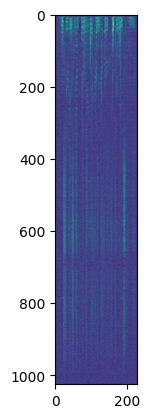

In [40]:
# mel_output = mel_input.reshape((N_CHANNELS, N_SAMPLES))
# mel_output = mel_output.detach().numpy()
# fig, ax = plt.subplots()
# S_out = librosa.power_to_db(mel_output, ref=np.max)
# img3 = librosa.display.specshow(S_out, x_axis='time',
#                          y_axis='mel', sr=fs,
#                          fmax=8000, ax=ax)
# ax.set(title='Mel output')

a_output = a_input.reshape((N_CHANNELS, N_SAMPLES))
a_output = a_output.detach().numpy()

plt.imshow(a_output)

In [41]:
import soundfile as sf

a = np.zeros_like(a_output)
a[:N_CHANNELS,:] = np.exp(a_output) - 1
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, n_fft=N_FFT))

OUTPUT_FILENAME = 'out.wav'
sf.write(OUTPUT_FILENAME, x, fs, 'PCM_24')

In [42]:
from IPython.display import Audio
Audio('out.wav')